# Ordinal Classification

In this project, the IUCN classes that form our response variable take the form of an ordinal system ranging from "LC" -- least concern -- to "CR" -- critically endangered. To move beyond binary classification, we can attempt to predict the specific class that each group belongs to. However, multiclass approaches will (by default) not account for the pseudo-numeric differences between our different classes.

One approach is to adapt our learning objective to a binary classifier[by decomposing ordinal classes into a series of sequential tasks](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf). This approach is conceptually similar to a one-vs-rest classifier:

* $P(y_i = LC) = 1 - P(y_i > LC)$ 
* $P(y_i = NT) = P(y_i > LC) - P(y_i > NT)$ 

$\dots$
* $P(y_i = CR) = P(y_i > CR)$

Assigned classes can then be generated by the maximum probability for each label.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [2]:
# Reading in datasets
features_std = pd.read_csv("../data/features_std.csv", index_col=0)
features_imp = pd.read_csv("../data/features_imputed.csv", index_col=0)
y_full = features_std["Red List status"]

In [3]:
# Defining new response variables 
def return_y_ordinal(y_dat):
    resp_ordinal = pd.get_dummies(y_dat).drop("LC", axis = 1)[["NT", "VU", "EN", "CR"]]
    resp_ordinal["EN"] = resp_ordinal["EN"] + resp_ordinal["CR"]
    resp_ordinal["VU"] = resp_ordinal["VU"] + resp_ordinal["EN"]
    resp_ordinal["NT"] = resp_ordinal["NT"] + resp_ordinal["VU"]
    
    return(resp_ordinal)

_Example of response structure:_

An example visualization of this new response variable is presented below.

In [4]:
new_y = return_y_ordinal(y_full)
response_example = new_y.drop_duplicates()
response_example.index = y_full[new_y.drop_duplicates().index]
response_example

,NT,VU,EN,CR
Red List status,,,,
LC,0,0,0,0
VU,1,1,0,0
EN,1,1,1,0
CR,1,1,1,1
NT,1,0,0,0


## Defining Ordinal Classifier

Following the above example, this function provides ordinal response predictions for a given classification object, `class_obj`

In [5]:
def OrdinalClassifier(class_obj, x_train, y_train, x_test, y_test):
    
    # First, run classifier on the lowest ordinal class
    class_obj.fit(x_train, y_train["NT"])
    cat_1_trprob = class_obj.predict_proba(x_train)
    cat_1_teprob = class_obj.predict_proba(x_test)
    
    # Repeat for second class
    class_obj.fit(x_train, y_train["VU"])
    cat_2_trprob = class_obj.predict_proba(x_train)
    cat_2_teprob = class_obj.predict_proba(x_test)
    
    # Repeat for third class
    class_obj.fit(x_train, y_train["EN"])
    cat_3_trprob = class_obj.predict_proba(x_train)
    cat_3_teprob = class_obj.predict_proba(x_test)
    
    # Repeat for fourth class
    class_obj.fit(x_train, y_train["CR"])
    cat_4_trprob = class_obj.predict_proba(x_train)
    cat_4_teprob = class_obj.predict_proba(x_test)
    
    # Returning ordinal class probabilities
    train_probs = pd.DataFrame(np.vstack([cat_1_trprob[:,1], cat_2_trprob[:,1], 
                                          cat_3_trprob[:,1], cat_4_trprob[:,1]]).transpose())

    test_probs = pd.DataFrame(np.vstack([cat_1_teprob[:,1], cat_2_teprob[:,1], 
                                         cat_3_teprob[:,1], cat_4_teprob[:,1]]).transpose())
    
    return(train_probs, test_probs)

__Evaluating Ordinal Classifier__

To evaluate this ordinal classification framework, I've chosen to classify species using support vector classification. Any classifier that returns class probabilities, however, should suffice. Through some initial tuning (not shown), rbf kernel SVC was found to an effective classifier. 

Here, I tune the regularization parameter, C, using K-fold stratified cross validation that may better take into account our observed class imbalance.

In [6]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(features_imp, y_full)

classlist = ["LC", "NT", "VU", "EN", "CR"]
mean_accuracy = []

for c_val in [1,2,3,4,5]:
    
    accuracy = []
    
    for train_index, test_index in skf.split(features_imp, y_full):

        # Setting features
        x_train = features_imp.loc[train_index]
        x_test = features_imp.loc[test_index]

        # Setting labels
        y_train = return_y_ordinal(y_full[train_index])
        y_test = return_y_ordinal(y_full[test_index])

        # Standardizing numeric variables
        stdscl = StandardScaler()
        stdscl.fit(x_train.iloc[:,57:60])
        x_train.iloc[:,57:60] = stdscl.transform(x_train.iloc[:,57:60])
        x_test.iloc[:,57:60] = stdscl.transform(x_test.iloc[:,57:60])

        # Running ordinal classification 
        classifier = SVC(kernel = "rbf", probability = True, C = c_val)
        tp, te = OrdinalClassifier(classifier, x_train, y_train, x_test, y_test)

        # Calculating predicted class probabilities
        baseclass_prob = 1 - te.loc[:,0]
        te.loc[:, 0] = te.loc[:, 0] - te.loc[:, 1]
        te.loc[:, 1] = te.loc[:, 1] - te.loc[:, 2]
        te.loc[:, 2] = te.loc[:, 2] - te.loc[:, 3]
        
        # Selecting max probability in each row as estimated class
        pred_classes = pd.concat([baseclass_prob, te], ignore_index=True, axis = 1).idxmax(axis=1)

        accuracy.append(accuracy_score(y_full[test_index], [classlist[pred] for pred in pred_classes]))
        
    print("CV run completed - C = %s" % str(c_val))
    
    mean_accuracy.append(np.mean(accuracy))        

CV run completed - C = 1
CV run completed - C = 2
CV run completed - C = 3
CV run completed - C = 4
CV run completed - C = 5


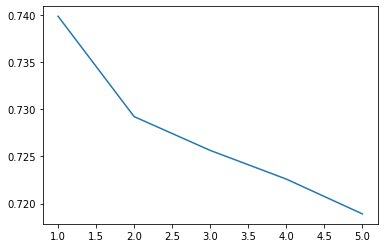

In [7]:
plt.plot([1,2,3,4,5], mean_accuracy)

__Confusion Matrix__

A confusion matrix trained on the full dataset is presented below, with entries standardized by row sums to illustrate accuracy on a by-class basis

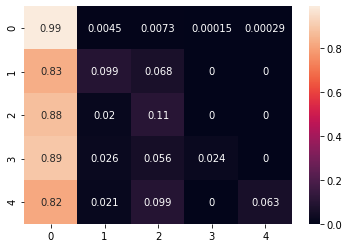

In [8]:
x_train = x_test = features_imp
y_train = y_test = return_y_ordinal(y_full)

stdscl = StandardScaler()
stdscl.fit(x_train.iloc[:,57:60])
x_train.iloc[:,57:60] = stdscl.transform(x_train.iloc[:,57:60])
        
classifier = SVC(kernel = "rbf", probability = True, C = 1)
tp, te = OrdinalClassifier(classifier, x_train, y_train, x_train, y_train)
     
baseclass_prob = 1 - te.loc[:,0]
te.loc[:, 0] = te.loc[:, 0] - te.loc[:, 1]
te.loc[:, 1] = te.loc[:, 1] - te.loc[:, 2]
te.loc[:, 2] = te.loc[:, 2] - te.loc[:, 3]

pred_classes = pd.concat([baseclass_prob, te], ignore_index=True, axis = 1).idxmax(axis=1)
        
cm = confusion_matrix(y_full, [classlist[pred] for pred in pred_classes], labels = classlist)
cm = pd.DataFrame(cm)
sns.heatmap(cm.div(cm.sum(axis=1), axis=0), annot = True)

While overall model accuracy is quite high, class imbalance causes many issues with this classifier -- a vast majority of observations in each class are assigned as "LC", class 0 on the x-axis.

## Ordinal classification with variable weights

To help mitigate effects of class imbalance, I've attempted to re-run this classifier using variable weights that place greater emphasis on positive labels. This approach would benefit from additional tuning and exploration of model weighting schemes, but appears to show improvements in average true positive rate across classes.

To do this, I've attempted to adapt the sklearn `class_weight` scheme to emphasize the importance of non-LC classes. In this case, probabilities are all classified by probability, then adjusted by class weights that are proportional to the relative frequency of each label.

(This would also benefit from more detailed cross-validation, if time allowed)

In [104]:
def OrdinalClassifier_Weighted(class_obj, x_train, y_train, x_test, y_test, c_weights):
    
    # First, run classifier on the lowest ordinal class
    weights = {'0': c_weights[0], '1': c_weights[1]}
    class_obj.set_params(class_weight = weights)
    class_obj.fit(x_train, y_train["NT"].astype("str"))
    cat_1_trprob = class_obj.predict_proba(x_train)
    cat_1_teprob = class_obj.predict_proba(x_test)
    
    # Repeat for second class
    weights = {'0': c_weights[0], '1': c_weights[2]}
    class_obj.set_params(class_weight = weights)
    class_obj.fit(x_train, y_train["VU"].astype("str"))
    cat_2_trprob = class_obj.predict_proba(x_train)
    cat_2_teprob = class_obj.predict_proba(x_test)
    
    # Repeat for third class
    weights = {'0': c_weights[0], '1': c_weights[3]}
    class_obj.set_params(class_weight = weights)
    class_obj.fit(x_train, y_train["EN"].astype("str"))
    cat_3_trprob = class_obj.predict_proba(x_train)
    cat_3_teprob = class_obj.predict_proba(x_test)
    
    # Repeat for fourth class
    weights = {'0': c_weights[0], '1': c_weights[4]}
    class_obj.set_params(class_weight = weights)
    class_obj.fit(x_train, y_train["CR"].astype("str"))
    cat_4_trprob = class_obj.predict_proba(x_train)
    cat_4_teprob = class_obj.predict_proba(x_test)
    
    # Returning ordinal class probabilities
    train_probs = pd.DataFrame(np.vstack([cat_1_trprob[:,1], cat_2_trprob[:,1], 
                                          cat_3_trprob[:,1], cat_4_trprob[:,1]]).transpose())

    test_probs = pd.DataFrame(np.vstack([cat_1_teprob[:,1], cat_2_teprob[:,1], 
                                         cat_3_teprob[:,1], cat_4_teprob[:,1]]).transpose())
    
    return(train_probs, test_probs)

Estimated accuracy using K-fold cross-validation

In [172]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(features_imp, y_full)

classlist = ["LC", "NT", "VU", "EN", "CR"]
accuracy = []

for train_index, test_index in skf.split(features_imp, y_full):

    # Setting features
    x_train = features_imp.loc[train_index]
    x_test = features_imp.loc[test_index]

    # Setting labels
    y_train = return_y_ordinal(y_full[train_index])
    y_test = return_y_ordinal(y_full[test_index])

    # Setting class weights per sklearn documentation, organized by class order
    c_weights = y_full.shape[0] / (5 * pd.get_dummies(y_full).sum(axis = 0)[[2,3,4,1,0]])

    # Standardizing numeric variables
    stdscl = StandardScaler()
    stdscl.fit(x_train.iloc[:,57:60])
    x_train.iloc[:,57:60] = stdscl.transform(x_train.iloc[:,57:60])

    # Running ordinal classification
    classifier = SVC(kernel = "rbf", probability = True, C = 1, class_weight = 'balanced')
    tp, te = OrdinalClassifier_Weighted(classifier, x_train, y_train, x_test, y_test, c_weights)

    # Calculating predicted class for test data
    baseclass_prob = 1 - te.loc[:,0]
    te.loc[:, 0] = te.loc[:, 0] - te.loc[:, 1]
    te.loc[:, 1] = te.loc[:, 1] - te.loc[:, 2]
    te.loc[:, 2] = te.loc[:, 2] - te.loc[:, 3]

    # Weighting, selecting max probability in each row as estimated class
    raw_prob = pd.concat([baseclass_prob, te], ignore_index=True, axis = 1)
    pred_classes =  pd.DataFrame(np.multiply(raw_prob, c_weights)).idxmax(axis = 1)

    accuracy.append(accuracy_score(y_full[test_index], [classlist[pred] for pred in pred_classes]))

np.mean(accuracy)

0.19722480693384975

__Confusion Matrix__

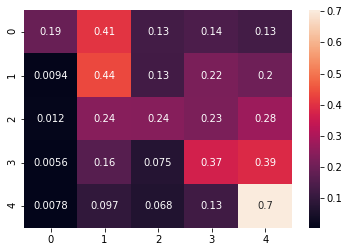

In [173]:
x_train = x_test = features_imp
y_train = y_test = return_y_ordinal(y_full)

# Setting class weights per sklearn documentation, organized by class order
c_weights = y_full.shape[0] / (5 * pd.get_dummies(y_full).sum(axis = 0)[[2,3,4,1,0]])

# Standardizing numeric variables
stdscl = StandardScaler()
stdscl.fit(x_train.iloc[:,57:60])
x_train.iloc[:,57:60] = stdscl.transform(x_train.iloc[:,57:60])
        
# Running ordinal classification
classifier = SVC(kernel = "rbf", probability = True, C = 1, class_weight = 'balanced')
tp, te = OrdinalClassifier_Weighted(classifier, x_train, y_train, x_train, y_train, c_weights)

# Calculating predicted class for test data
baseclass_prob = 1 - te.loc[:,0]
te.loc[:, 0] = te.loc[:, 0] - te.loc[:, 1]
te.loc[:, 1] = te.loc[:, 1] - te.loc[:, 2]
te.loc[:, 2] = te.loc[:, 2] - te.loc[:, 3]

# Weighting, selecting max probability in each row as estimated class
raw_prob = pd.concat([baseclass_prob, te], ignore_index=True, axis = 1)
pred_classes =  pd.DataFrame(np.multiply(raw_prob, c_weights)).idxmax(axis = 1)

cm = confusion_matrix(y_full, [classlist[pred] for pred in pred_classes], labels = classlist)
cm = pd.DataFrame(cm)
sns.heatmap(cm.div(cm.sum(axis=1), axis=0), annot = True)

While accuracy of the largest class, "CR", is maximized in this fashion, overall accuracy suffers with this design. Critically, misclassification using a class smaller than the target label is greatly reduced. If tolerance for false possitives is high, this approach may be reasonable.

This outcome also highlights the difficulty in extending the previously defined approach to a weighting scheme. Changes to the way class weights are applied or further tuning of these weights will likely improve overall model accuracy -- as currently formulated, too much weight is placed on the estimation of the largest class.

## Multi-Class Classification for Comparison

In [16]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(features_imp, y_full)

classlist = ["LC", "NT", "VU", "EN", "CR"]

accuracy = []

for train_index, test_index in skf.split(features_imp, y_full):

    # Setting features
    x_train = features_imp.loc[train_index]
    x_test = features_imp.loc[test_index]

    # Setting labels
    y_train = y_full[train_index]
    y_test = y_full[test_index]

    # Standardizing numeric variables
    stdscl = StandardScaler()
    stdscl.fit(x_train.iloc[:,57:60])
    x_train.iloc[:,57:60] = stdscl.transform(x_train.iloc[:,57:60])
    x_test.iloc[:,57:60] = stdscl.transform(x_test.iloc[:,57:60])

    # Running ordinal classification 
    classifier = SVC(kernel = "rbf", probability = True, C = 1, 
                     class_weight = 'balanced', decision_function_shape = "ovr")
    classifier.fit(x_train, y_train)

    # Selecting max probability in each row as estimated class
    pred_classes = classifier.predict(x_test)

    accuracy.append(accuracy_score(y_test, pred_classes))

np.mean(accuracy)

0.42573678057766334

__Confusion Matrix__

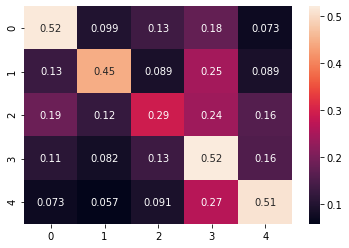

In [38]:
x_train = x_test = features_imp
y_train = y_test = y_full

stdscl = StandardScaler()
stdscl.fit(x_train.iloc[:,57:60])
x_train.iloc[:,57:60] = stdscl.transform(x_train.iloc[:,57:60])
        
classifier = SVC(kernel = "rbf", probability = True, C = 1, 
                         class_weight = 'balanced', decision_function_shape = "ovr")

classifier.fit(x_train, y_train)

pred_classes = classifier.predict(x_test)
        
cm = confusion_matrix(y_full, pred_classes, labels = classlist)
cm = pd.DataFrame(cm)
sns.heatmap(cm.div(cm.sum(axis=1), axis=0), annot = True)

In this multiclass design, misclassification rates are lower than that of the ordinal classification approach. However, misclassification appears to show less of a consistent pattern -- while classes are likely to be mislabelled as one of their adjacent classes, false positives and false negatives appear similarly likely for many observations.

# Conclusions:

Fish conservation status, generally, appears to show some degree of correlation with life history traits. Whether considered as a binary classification task or an ordinal one, existing databases are likely to inform ongoing efforts to prioritize conservation effort.

Such applications are not without their challenges, however. Sparsity of online databases can present challenges to effective classification, and easy-to-measure variables may not capture a number of the key features that make a fish likely to be "of conservation concern". 

Ordinal classification, in particular, appears to be a difficult task, in part due to the often unbalanced nature of class labels. Though time intensive, appropriate tuning of model hyperparameters will likely increase the value of ordinal classification schemes. Depending on the goals of classification (tolerance for false positives, etc.), various solutions are possible. 